# Visualisation of the mean situation in the Irminger Sea

We visualise a number of properties in the Irminger Sea averaged over the whole time series from 1993-2019. All these properties have been depth-averaged over the upper 600 m of the water column (a weighted average taking into account the layer thickness).

In [1]:
import numpy as np
import netCDF4 as nc
import scipy.io as sio
import scipy.ndimage as ndim
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_style('dark')
from info import datadir, figdir, bounds_lon, bounds_lat

import warnings
warnings.filterwarnings('ignore')

## Load data

### General stuff

In [2]:
# DCA contour
x = np.load(datadir+'DCA_contour_x.npy')
y = np.load(datadir+'DCA_contour_y.npy')

# Bathymetry
topodata = sio.loadmat(datadir+'subpolartopo.mat')
topo = topodata['topogrid']
topo_lat = topodata['topolat']
topo_lon = topodata['topolon']

ind_lat_lower = np.argwhere(topo_lat[0,:]<=bounds_lat[1])[0][0]
ind_lat_upper = np.argwhere(topo_lat[0,:]>=bounds_lat[0])[-1][0]
ind_lon_left = np.argwhere(topo_lon[:,0]>=bounds_lon[0])[0][0]
ind_lon_right = np.argwhere(topo_lon[:,0]<=bounds_lon[1])[-1][0]

sublat = topo_lat[ind_lon_left:ind_lon_right+1,ind_lat_lower:ind_lat_upper+1]
sublon = topo_lon[ind_lon_left:ind_lon_right+1,ind_lat_lower:ind_lat_upper+1]
subtopo = topo[ind_lon_left:ind_lon_right+1,ind_lat_lower:ind_lat_upper+1]
subtopo_smooth = ndim.gaussian_filter(subtopo,sigma=1)

### Hydrographic properties (CMEMS)

In [3]:
# Coordinates
coords = sio.loadmat(datadir+'propertiesIrminger_coords.mat')
time = coords['time'][0]
lat = coords['lat'][0]
lon = coords['lon'][0]
Lon, Lat = np.meshgrid(lon,lat)

# Mean properties
prop_mean = sio.loadmat(datadir+'propertiesIrminger_mean.mat')
S_mean = prop_mean['S']
T_mean = prop_mean['T']
u_mean = prop_mean['u']
v_mean = prop_mean['v']
vel_mean = np.sqrt(u_mean**2 + v_mean**2)
EKE_mean = prop_mean['EKE']

### Atmospheric fluxes (ERA5)

In [4]:
fn = datadir+'ERA5_1993-2019_monthly_mean.nc'
ds = nc.Dataset(fn)

lat_ERA = ds['latitude'][:]
lon_ERA = ds['longitude'][:]
Lon_ERA, Lat_ERA = np.meshgrid(lon_ERA,lat_ERA)

E = ds['e'][:] # evaporation
P = ds['tp'][:] # total precipitation
E_P = E+P # net freshwater flux

slhf = ds['slhf'][:] # surface upward latent heat flux
ssr = ds['ssr'][:] # surface net downward shortwave flux (solar radiation)
strr = ds['str'][:] # surface net upward longwave flux (thermal radiation)
sshf = ds['sshf'][:] # surface upward sensible heat flux
Q = slhf+ssr+strr+sshf # total heat flux

# Time-mean fields
E_P_mean = np.average(E_P,axis=0)
Q_mean = np.average(Q,axis=0)

## Some plotting functions

In [5]:
def sampleValues(data,lat_vals,lon_vals):
    """
    Get the values of a data set only at certain latitudes and longitudes
    """
    ind_lat = np.zeros(len(lat_vals),int)
    for i in range(len(lat_vals)):
        ind_lat[i] = int(np.argwhere(lat==lat_vals[i]))
        
    ind_lon = np.zeros(len(lon_vals),int)
    for i in range(len(lon_vals)):
        ind_lon[i] = int(np.argwhere(lon==lon_vals[i]))
    
    data_new = data[np.meshgrid(ind_lat,ind_lon)]
    return data_new


def axSettingsLC(ax,bounds_lon,bounds_lat,eps=0.05):
    """
    axes settings for Lambert Conformal projection
    """
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.LAND, zorder=100, edgecolor='black', facecolor=(0.8,0.8,0.8))
    rect_lon=[bounds_lon[0]-eps, bounds_lon[1]+eps]
    rect_lat=[bounds_lat[0]-eps, bounds_lat[1]+eps]
    rect = mpath.Path([[rect_lon[0], rect_lat[0]],
                        [rect_lon[1], rect_lat[0]],
                        [rect_lon[1], rect_lat[1]],
                        [rect_lon[0], rect_lat[1]],
                        [rect_lon[0], rect_lat[0]],
                        ]).interpolated(20)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_extent([bounds_lon[0], bounds_lon[1], bounds_lat[0] - 0.5, bounds_lat[1]])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), alpha=0)
    gl.xlocator = mticker.FixedLocator(np.arange(5*round(bounds_lon[0]/5),5*round(bounds_lon[1]/5)+0.1,5))
    gl.ylocator = mticker.FixedLocator(np.arange(5*round(bounds_lat[0]/5),5*round(bounds_lat[1]/5)+0.1,5))
    gl.xlabels_bottom = True
    gl.x_inline = False
    gl.xlabel_style = {'size': 12}
    gl.ylabels_left = True
    gl.ylabel_style = {'size': 12}

    
def plotData(ax,Lon,Lat,data,bounds_lon,bounds_lat,levels,ticks,shrink,ext,cmap,label):
    """
    Plot a certain data field in the Irminger Sea
    """
    p = ax.contourf(Lon,Lat,data,levels=levels,extend=ext,cmap=cmap,transform=ccrs.PlateCarree())
    cbar = fig.colorbar(p, ax=ax, shrink = shrink, anchor=(1.35,0.5), ticks=ticks)
    cbar.set_label(label, fontsize=15)
    cbar.ax.tick_params(labelsize=13)
    cbar.ax.get_yaxis().labelpad = 20
    axSettingsLC(ax,bounds_lon,bounds_lat)
    
projection = ccrs.LambertConformal(central_longitude=np.mean(bounds_lon),central_latitude=np.mean(bounds_lat))

## Sampling velocity values for vectors

First we sample the velocity values at 1/3 degree intervals. We separate the sampled locations into locations where the velocity magnitude is larger or smaller than 0.07 m/s, so that we can plot these arrows separately.

In [6]:
lat_quiver = np.arange(58,65.25,1/3)
lon_quiver = np.arange(-45,-26.75,1/3)
u_mean_q = sampleValues(u_mean,lat_quiver,lon_quiver)
v_mean_q = sampleValues(v_mean,lat_quiver,lon_quiver)

vellarge=np.where(u_mean_q**2 + v_mean_q**2 > 0.07**2)

# Only the locations where velocities are smaller than 0.07 m/s
u_small = np.copy(u_mean_q)
v_small = np.copy(v_mean_q)
u_small[vellarge] = np.nan
v_small[vellarge] = np.nan

# Only the locations where velocities are larger than 0.07 m/s
u_large = np.copy(u_mean_q)
v_large = np.copy(v_mean_q)
u_large[~np.isnan(u_small)] = np.nan
v_large[~np.isnan(v_small)] = np.nan

## Figures

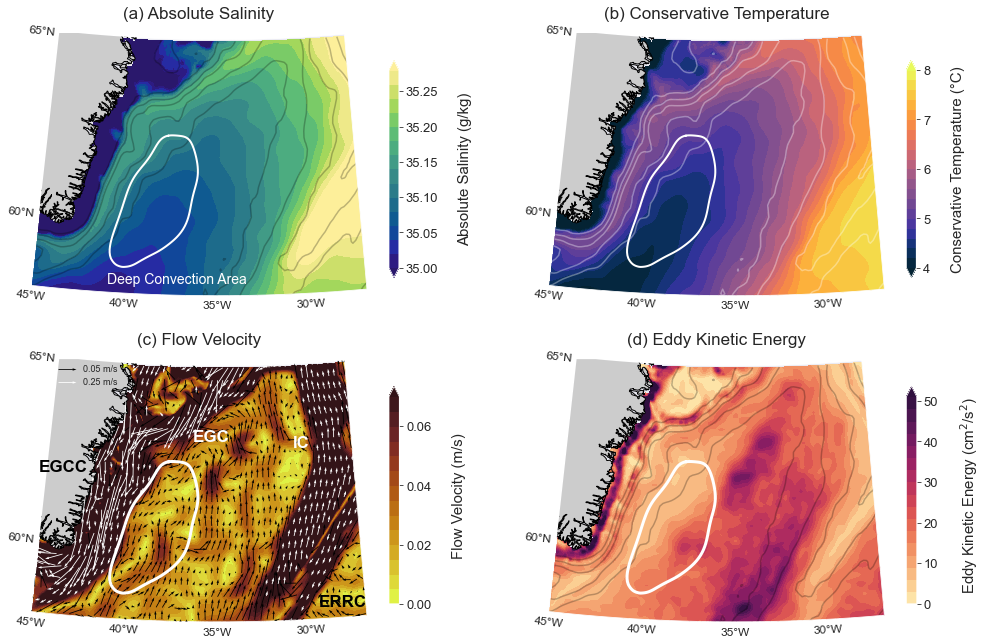

In [10]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(17,11), subplot_kw={'projection': projection})

plotData(ax1,Lon,Lat,S_mean,[-45,-27],[58,65],
         levels=np.arange(35,35.28,0.02),ticks=np.arange(35,35.26,0.05),
         shrink=0.8, ext='both', cmap='cmo.haline', label='Absolute Salinity (g/kg)')
ax1.contour(sublon,sublat,subtopo_smooth, levels=[-2500,-2000,-1500,-1000,-500],
            colors='black',linestyles='solid', transform=ccrs.PlateCarree(), alpha=0.25)
ax1.plot(x,y,color='white',linewidth=2, transform=ccrs.PlateCarree())
ax1.text(np.min(x),np.min(y)-0.5,'Deep Convection Area', color='white',fontsize=14, transform=ccrs.PlateCarree())
ax1.set_title('(a) Absolute Salinity',fontsize=17)

plotData(ax2,Lon,Lat,T_mean,[-45,-27],[58,65],
         levels=np.arange(4,8.01,0.2),ticks=np.arange(4,8.01,1),
         shrink=0.8, ext='both', cmap='cmo.thermal', label='Conservative Temperature ('+'\u00B0'+'C)')
ax2.contour(sublon,sublat,subtopo_smooth, levels=[-2500,-2000,-1500,-1000,-500],
            colors='white',linestyles='solid', transform=ccrs.PlateCarree(), alpha=0.35)
ax2.plot(x,y,color='white',linewidth=2, transform=ccrs.PlateCarree())
ax2.set_title('(b) Conservative Temperature',fontsize=17)

plotData(ax3,Lon,Lat,vel_mean,[-45,-27],[58,65],
         levels=np.arange(0,0.071,0.005),ticks=np.arange(0,0.071,0.02),
         shrink=0.8, ext='max', cmap='cmo.solar_r', label='Flow Velocity (m/s)')
Qsmall=ax3.quiver(lon_quiver,lat_quiver,np.transpose(u_small),np.transpose(v_small),transform=ccrs.PlateCarree(),
           scale=0.2,scale_units='inches',color='black',zorder=110)
Qlarge=ax3.quiver(lon_quiver,lat_quiver,np.transpose(u_large),np.transpose(v_large),transform=ccrs.PlateCarree(),
           scale=1,scale_units='inches',color='white',zorder=110)
QKsmall = ax3.quiverkey(Qsmall,0.135,0.965,0.05,'0.05 m/s',labelpos='E',coordinates='axes',fontproperties={'size':9},zorder=110)
QKlarge = ax3.quiverkey(Qlarge,0.135,0.915,0.25,'0.25 m/s',labelpos='E',coordinates='axes',fontproperties={'size':9},zorder=110)
ax3.plot(x,y,color='white',linewidth=3, transform=ccrs.PlateCarree(),zorder=115)
ax3.text(-36.5,63,"EGC",color='white',fontweight='bold',fontsize=17, transform=ccrs.PlateCarree(),zorder=115)
ax3.text(-30.5,62.787,"IC",color='white',fontweight='bold',fontsize=17, transform=ccrs.PlateCarree(),zorder=115)
ax3.text(-29.5,58.3,"ERRC",color='black',fontweight='bold',fontsize=17, transform=ccrs.PlateCarree(),zorder=115)
ax3.text(-45.5,61.9,"EGCC",color='black',fontweight='bold',fontsize=17, transform=ccrs.PlateCarree(),zorder=115)
ax3.set_title('(c) Flow Velocity',fontsize=17)

plotData(ax4,Lon,Lat,EKE_mean*1e4,[-45,-27],[58,65],
         levels=np.arange(0,52,3),ticks=np.arange(0,52,10),
         shrink=0.8, ext='max', cmap='cmo.matter', label='Eddy Kinetic Energy (cm$^2$/s$^2$)')
ax4.contour(sublon,sublat,subtopo_smooth, levels=[-2500,-2000,-1500,-1000,-500],
            colors='black',linestyles='solid', transform=ccrs.PlateCarree(), alpha=0.25)
ax4.plot(x,y,color='white',linewidth=3, transform=ccrs.PlateCarree())
ax4.set_title('(d) Eddy Kinetic Energy',fontsize=17)

plt.savefig(figdir+'properties_mean.pdf',bbox_inches='tight')
plt.show()

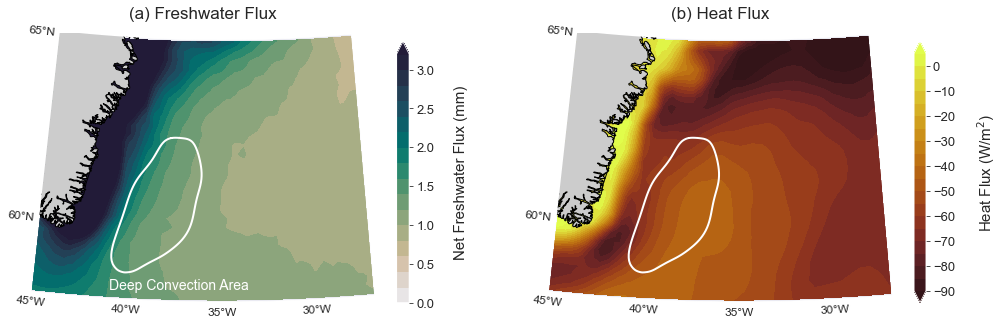

In [8]:
fig, ((ax1,ax2)) = plt.subplots(nrows=1,ncols=2,figsize=(17,6), subplot_kw={'projection': projection})

plotData(ax1,Lon_ERA,Lat_ERA,E_P_mean*1e3,[-45,-27],[58,65],
         levels=np.arange(0,3.21,0.2),ticks=np.arange(0,3.21,0.5),
         shrink=0.8, ext='max', cmap='cmo.rain', label='Net Freshwater Flux (mm)')
ax1.plot(x,y,color='white',linewidth=2, transform=ccrs.PlateCarree())
ax1.text(np.min(x),np.min(y)-0.5,'Deep Convection Area', color='white',fontsize=14, transform=ccrs.PlateCarree())
ax1.set_title('(a) Freshwater Flux',fontsize=17)

plotData(ax2,Lon_ERA,Lat_ERA,Q_mean/(24*60*60),[-45,-27],[58,65],
         levels=np.arange(-90,5.1,5),ticks=np.arange(-90,5,10),
         shrink=0.8, ext='both', cmap='cmo.solar', label='Heat Flux (W/m$^2$)')
ax2.plot(x,y,color='white',linewidth=2, transform=ccrs.PlateCarree())
ax2.set_title('(b) Heat Flux',fontsize=17)

plt.savefig(figdir+'surface_forcing_mean_map.pdf',bbox_inches='tight')
plt.show()